In [1]:
from IPython.display import SVG, display

# Declaración de MACROS
base_board = '<svg x="0px" y="0px" width="400px" viewBox="0 0 300 300" style="enable-background:new 0 0 300 300;" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><symbol id="queen" viewBox="000 00 500 550"><path id="queen" d="M477.518 181.966a25 25 0 0 1-34.91 23l-62.29 150.26h-248.92l-62.24-150.19a25 25 0 1 1 9.73-7.29l87 71.2 20.92-126.4a25 25 0 1 1 14.7-1.85l54.31 117 54.42-117.3a25 25 0 1 1 14.58 2.08l20.93 126.42 87.26-71.3a25 25 0 1 1 44.51-15.63zm-71.66 241.25h-300v60h300v-60zm-27.75-52h-244.22v36h244.22v-36z"/></symbol>{}</svg>'
queen = '<use xlink:href="#queen" x="{}" y="{}" width="{}" height="{}" fill="{}" stroke="black" stroke-width="20px"/>'

# Representa un tablero dadas las reinas
def display_board(queens):
    N_size = 300 / len(queens)
    board = base_board
    aux_board = ''
    for i in range(len(queens)):
        for j in range(len(queens)):
            color = ('#eeeed2', '#779455')[(i + j) % 2]  # (light, dark)
            aux_board += '<rect x="{}" y="{}" width="{}" height="{}" fill="{}"/>'.format(
                i*N_size, j*N_size, N_size, N_size, color)
    
    # Different color for collisions
    for i in range(len(queens)):
        collision = False
        if queens[i] >= 0 and queens[i] < len(queens):
            for j in range(len(queens)):
                if i != j and (queens[j] == queens[i] or abs(queens[j] - queens[i]) == abs(j - i)):
                    collision = True
                    aux_board += queen.format(i*N_size, queens[i]*N_size, N_size, N_size, '#ff4c4c')
                    break
            if not collision:
                aux_board += queen.format(i*N_size, queens[i]*N_size, N_size, N_size, 'white')


    board = board.format(aux_board)
    display(SVG(data=board))

In [2]:
from NReinas import NQueensBaseAnnealer

# Prueba una codificación del problema para N reinas, tomando métricas un update_ratio% de las épocas máximas
def test_annealer_auto(Ann, N=50, update_ratio=None):
    ann = Ann(n_queens=N)
    schedule = ann.auto(minutes=1)
    ann = Ann(n_queens=N)
    ann.set_schedule(schedule)
    if update_ratio:
        ann.updates = update_ratio * ann.steps
    best_sol, best_cost = ann.anneal()
    print(f'\nschedule: {schedule}')
    print(f'Nº collisions {best_cost}')
    print(f'Nº epochs {ann.epochs}')
    display_board(best_sol)
    ann.plot_evolution()

# Igual que el anterior, sin estimación de parámetros
def test_annealer(Ann, N=50, update_ratio=None, t_max=25000, t_min=2.5, steps=50000, L=1):
    ann = Ann(n_queens=N)
    ann.Tmax = t_max
    ann.Tmin = t_min
    ann.steps = steps
    ann.L = L
    if update_ratio:
        ann.updates = update_ratio * ann.steps
    best_sol, best_cost = ann.anneal()
    print(f'Nº collisions {best_cost}')
    print(f'Nº epochs {ann.epochs}')
    display_board(best_sol)
    ann.plot_evolution()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.09976          1.00     9.00%     0.00%     0:00:07     0:00:00

Nº collisions 0
Nº epochs 9452


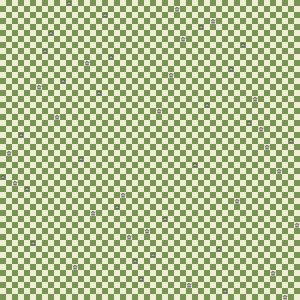

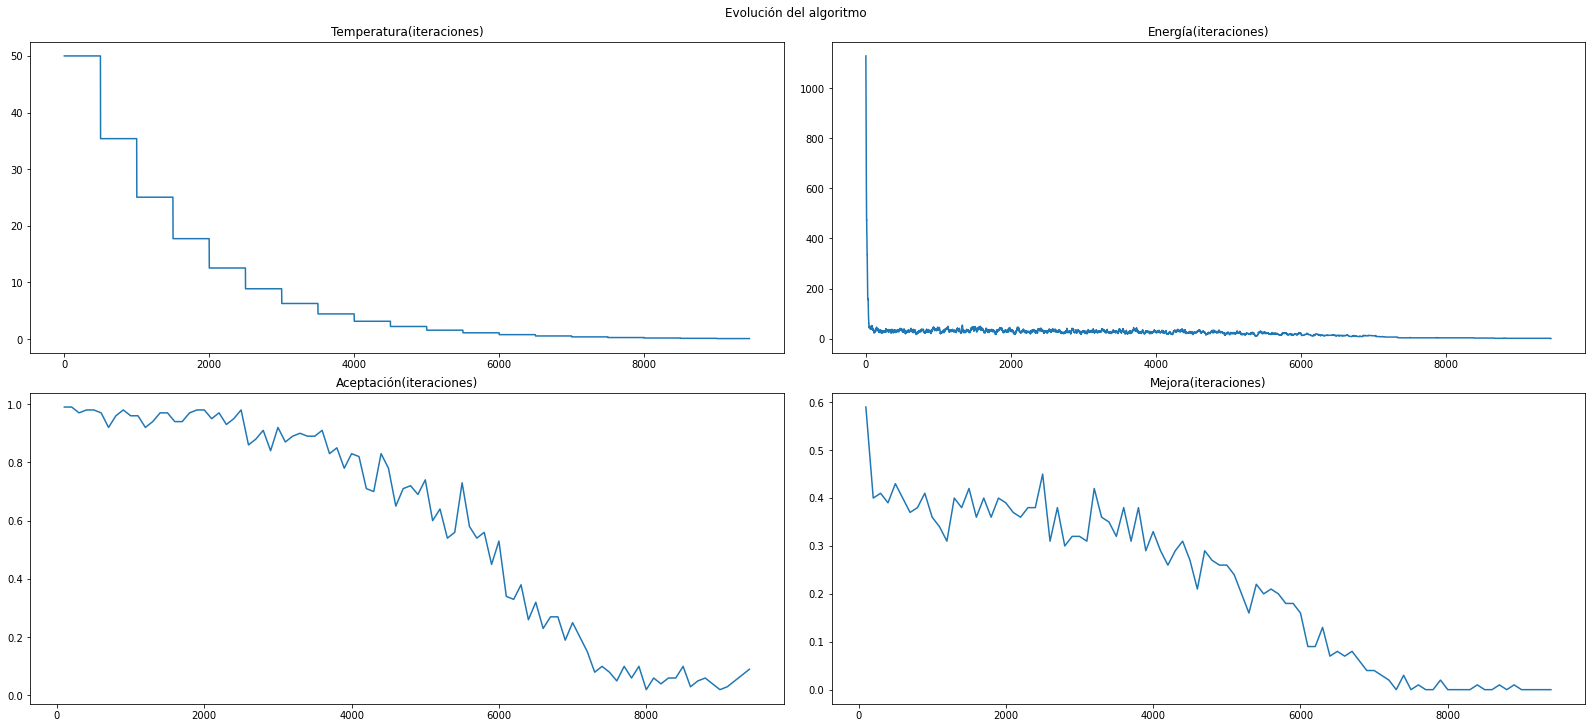

In [4]:
test_annealer(NQueensBaseAnnealer, N=50, update_ratio=None, t_max=50, t_min=0.05, steps=10000, L=500)

In [ ]:
from NReinas import NQueensBaseAnnealer, Alt1NQueensBaseAnnealer, Alt2NQueensBaseAnnealer

cods = {
    'Básica': NQueensBaseAnnealer,
    'Alternativa1': Alt1NQueensBaseAnnealer,
    'Alternativa2': Alt2NQueensBaseAnnealer
}
def run_experiment(N, codification, update_ratio, auto, t_max, t_min, steps):
    ann = cods[codification]
    update_ratio = None if update_ratio == 0.0 else update_ratio
    if auto:
        test_annealer_auto(ann, N, update_ratio=update_ratio)
    else:
        test_annealer(ann, N, update_ratio, t_max, t_min, steps)

In [ ]:
from ipywidgets import interact_manual
from ipywidgets import widgets as wdg


class FitDescriptionWidget(wdg.VBox, wdg.ValueWidget):
    def __init__(self, widget, *args):
        self.description = ''.join(args)
        labels = [wdg.Label(l, layout=wdg.Layout(
                margin='0 0 -9px 5px'),) for l in args]
        self.widget = widget
        super().__init__(labels + [widget],
            layout=wdg.Layout(
                border='1px dashed black',
                width='75%'),
        )

    def get_interact_value(self):
        return self.widget.get_interact_value()

N_opt = FitDescriptionWidget(wdg.IntSlider(
    value=7,
    min=1,
    max=200,
    step=1,
    description='Nº Reinas',
), 'Número de reinas:')
codification_opt = FitDescriptionWidget(wdg.Select(
    options=['Básica', 'Alternativa1', 'Alternativa2'],
    value='Básica',
    description='Codificación: ',
), 'Codificaciones del algoritmo: definición del entorno y codificación de las soluciones.',
   '⟶ Básica: Impide colisiones en filas y columnas. Entorno: cambio de dos reinas.',
   '⟶ Alternativa1: Impide colisiones en columnas. Entorno: mover reina aleatoria a fila aleatoria en su columna.',
   '⟶ Alternativa2: Impide colisiones en columnas. Entorno: mover reina aleatoria una fila arriba o abajo en su columna.' 
)
update_ratio_opt = FitDescriptionWidget(wdg.FloatSlider(
    value=0.00,
    min=0.00,
    max=1.00,
    step=0.005,
    description='Ratio métricas:',
    style={'description_width': 'initial'}
), 'Porcentaje del máximo de iteraciones del que se toman métricas. Conviene fijarlo ~1.00 si el Nº de reinas es pequeño,',
   ' pues se puede alcanzar la condición de parada antes de recoger suficientes métricas.',
   'Si 0, se tomarán 100 métricas a lo largo del total de iteraciones (salvo por alcanzar condición de parada)')

auto_opt = FitDescriptionWidget(wdg.Checkbox(
    value=True,
    description='Modo auto:',
), 'Estimar hiperparámetros automáticamente.')

t_max_opt = FitDescriptionWidget(
    wdg.FloatText(value='50.0', description='Tmáx:'),
    'Temperatura máxima. Solo se usa el valor si auto es False.'
)

t_min_opt = FitDescriptionWidget(
    wdg.FloatText(value='01.0', description='Tmín:'),
    'Temperatura mínima. Solo se usa el valor si auto es False.'
)

steps_opt = FitDescriptionWidget(
    wdg.IntText(value='1000', description='steps:'),
    'Máximo de iteraciones. Solo se usa el valor si auto es False.'
)

interact_manual(
    run_experiment,
    N=N_opt,
    codification=codification_opt,
    update_ratio=update_ratio_opt,
    auto=auto_opt,
    t_max=t_max_opt,
    t_min=t_min_opt,
    steps=steps_opt
)